# Read in the data & Data cleansing

In [3]:
import pandas as pd
import numpy as np
import matplotlib
from datetime import datetime
#pip install nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from matplotlib import pylab as plt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost
from sklearn.model_selection import ParameterGrid
import shap

D:\ProgramData\Anaconda3\envs\data1030\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
trending_data = pd.read_csv('../data/US_youtube_trending_data.csv')
channel_data = pd.read_csv('../data/channels.csv')

In [5]:
trending_days = pd.DataFrame(trending_data.value_counts(trending_data['video_id']), columns=['trending_days'])
trending_data = pd.merge(trending_data, trending_days, left_on='video_id', right_on='video_id')

In [6]:
df_merge = pd.merge(trending_data, channel_data, left_on='channelId', right_on='channel_id')
df = df_merge.drop_duplicates(subset='video_id', keep='first')
df = df.reset_index(drop=True)
df = df.rename(columns={'title_x': 'video_title', 'title_y': 'channel_title', 'description_x': 'video_description', 'description_y': 'channel_description'})

In [7]:
df['publishedAt'] = pd.to_datetime(df['publishedAt'])
df['trending_date'] = pd.to_datetime(df['trending_date'])
df['join_date'] = pd.to_datetime(df['join_date'])
df['join2publish'] = (df['publishedAt'].apply(lambda x: x.replace(tzinfo=None))-df['join_date']).dt.days
df['publish2trend'] = (pd.to_datetime(df_merge.drop_duplicates(subset='video_id', keep='first').reset_index(drop=True)['trending_date'])-pd.to_datetime(df_merge.drop_duplicates(subset='video_id', keep='first').reset_index(drop=True)['publishedAt'])).dt.days+1

In [8]:
df['video_title'] = df['video_title'].str.lower()
df['tags'] = df['tags'].str.lower()

interpunctuations = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%', '|', '–', '“', '”', '-', '..', '...', "'", '‘', '’']
stops = set(stopwords.words("english"))

wordfreq_videotitle = []
wordfreq_tag = []

cutword_videotitle = word_tokenize(' '.join(df['video_title']))
cutword_videotitle = [word for word in cutword_videotitle if word not in interpunctuations]
cutword_videotitle = [word for word in cutword_videotitle if word not in stops]
for word in cutword_videotitle:
    wordfreq_videotitle.append(WordNetLemmatizer().lemmatize(word, pos='v'))
wordfreq_videotitle = pd.value_counts(wordfreq_videotitle)

cutword_tag = word_tokenize(' '.join(' '.join(df['tags']).split('|')))
cutword_tag = [word for word in cutword_tag if word not in interpunctuations]
cutword_tag = [word for word in cutword_tag if word not in stops]
for word in cutword_tag:
    wordfreq_tag.append(WordNetLemmatizer().lemmatize(word, pos='v'))
wordfreq_tag = pd.value_counts(wordfreq_tag)

In [9]:
print(wordfreq_videotitle.head(10))
wordfreq5_videotitle = ['official', 'video', 'highlight', 'trailer', 'game']
print(wordfreq_tag.head(10))
wordfreq5_tag = ['game', 'minecraft', 'new', 'highlight', 'video']

official     2184
video        1685
's           1463
highlight     980
trailer       942
game          811
new           717
music         676
2             672
2021          670
dtype: int64
game         5250
minecraft    4488
new          4215
highlight    3555
video        3418
fortnite     3011
music        2725
nba          2654
funny        2635
news         2512
dtype: int64


In [10]:
for i in wordfreq5_videotitle:
    df['vtitle_'+i] = df['video_title'].str.contains(i)
for i in wordfreq5_tag:
    df['tag_'+i] = df['tags'].str.contains(i)

In [11]:
df = df.drop(['video_id', 'channelId', 'thumbnail_link', 'category_id', 'categoryId', 'channel_id', 'picture_url', 'profile_url', 'trailer_url', 'location'], axis=1)
df = df.drop(['publishedAt', 'trending_date', 'join_date'], axis=1)
df = df.drop(['video_title', 'channelTitle', 'tags', 'video_description', 'channel_title', 'trailer_title', 'channel_description'], axis=1)

In [12]:
df

,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,trending_days,category_name,country,followers,...,vtitle_official,vtitle_video,vtitle_highlight,vtitle_trailer,vtitle_game,tag_game,tag_minecraft,tag_new,tag_highlight,tag_video
0,1514614,156908,5855,35313,False,False,7,People & Blogs,United States,3096020,...,False,False,False,False,False,False,False,False,False,True
1,1471847,127670,4110,17904,False,False,5,People & Blogs,United States,3096020,...,False,False,False,False,False,False,False,False,False,True
2,2530061,219190,3395,29439,False,False,6,People & Blogs,United States,3096020,...,False,False,False,False,False,False,False,False,False,True
3,918791,68090,1175,5131,False,False,9,People & Blogs,United States,3096020,...,False,False,False,False,False,False,False,False,False,True
4,1515393,120809,12603,30531,False,False,8,People & Blogs,United States,3096020,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18064,494705,32642,0,1494,False,False,4,People & Blogs,NaN,771865,...,False,False,False,False,False,False,False,False,False,False
18065,266278,8075,0,5240,False,False,3,Gaming,NaN,221624,...,False,False,False,False,False,False,False,False,False,False
18066,694490,43462,0,1159,False,False,3,People & Blogs,México,88883,...,False,False,False,False,False,False,False,False,False,False
18067,470280,26907,0,1884,False,False,1,Gaming,United States,640677,...,False,False,False,False,False,True,False,False,False,False


# EDA

In [11]:
print(df.shape)
print(df.dtypes)

(18069, 23)
view_count             int64
likes                  int64
dislikes               int64
comment_count          int64
comments_disabled       bool
ratings_disabled        bool
trending_days          int64
category_name         object
country               object
followers              int64
videos                 int64
join2publish         float64
publish2trend          int64
vtitle_official         bool
vtitle_video            bool
vtitle_highlight        bool
vtitle_trailer          bool
vtitle_game             bool
tag_game                bool
tag_minecraft           bool
tag_new                 bool
tag_highlight           bool
tag_video               bool
dtype: object


In [12]:
print(df['trending_days'].describe())

count    18069.000000
mean         5.485804
std          2.025103
min          1.000000
25%          4.000000
50%          5.000000
75%          6.000000
max         35.000000
Name: trending_days, dtype: float64


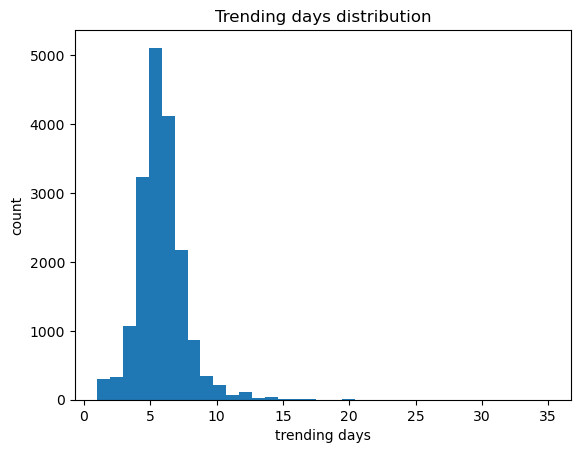

In [52]:
df['trending_days'].plot.hist(bins=np.max(df['trending_days']))
plt.xlabel('trending days')
plt.ylabel('count')
plt.title("Trending days distribution")
plt.savefig("../figures/trending days.jpg", bbox_inches='tight', dpi=300)
plt.show()

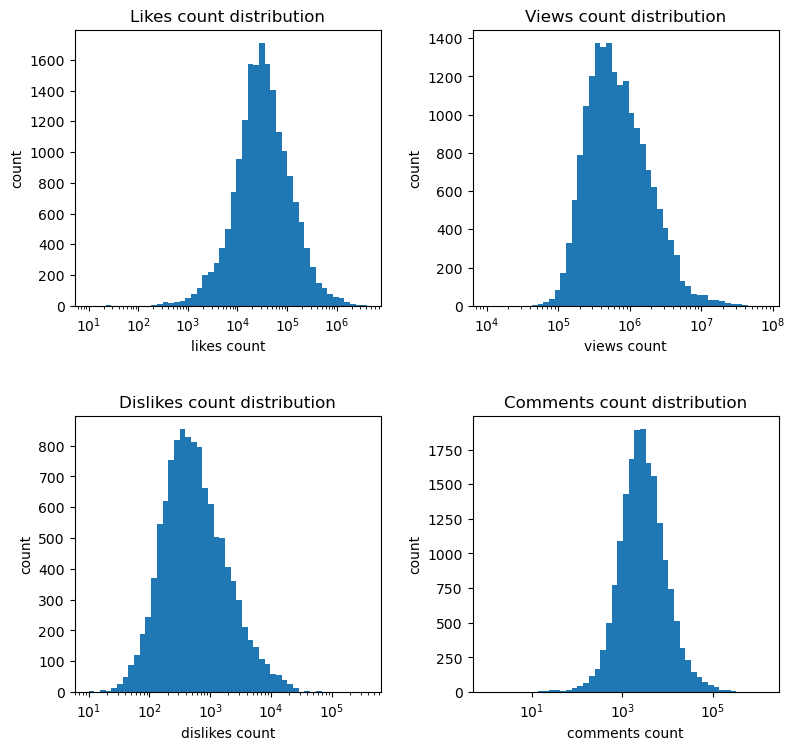

In [53]:
sub1 = plt.subplot(221)
df['likes'].plot.hist(bins=np.logspace(1, np.log10(np.max(df['likes'])),50))
sub1.semilogx()
sub1.set_xlabel('likes count')
sub1.set_ylabel('count')
sub1.set_title("Likes count distribution")

sub2 = plt.subplot(222)
df['view_count'].plot.hist(bins=np.logspace(4, np.log10(np.max(df['view_count'])),50)) 
sub2.semilogx()
sub2.set_xlabel('views count')
sub2.set_ylabel('count')
sub2.set_title("Views count distribution")

sub3 = plt.subplot(223)
df['dislikes'].plot.hist(bins=np.logspace(1, np.log10(np.max(df['dislikes'])),50)) 
sub3.semilogx()
sub3.set_xlabel('dislikes count')
sub3.set_ylabel('count')
sub3.set_title("Dislikes count distribution")

sub4 = plt.subplot(224)
df['comment_count'].plot.hist(bins=np.logspace(np.log10(1), np.log10(np.max(df['comment_count'])),50)) 
sub4.semilogx()
sub4.set_xlabel('comments count')
sub4.set_ylabel('count')
sub4.set_title("Comments count distribution")

plt.subplots_adjust(left=-0.2, bottom=-0.5, wspace=0.3, hspace=0.4)
plt.savefig("../figures/video distribution info.jpg", bbox_inches='tight', dpi=300)
plt.show()

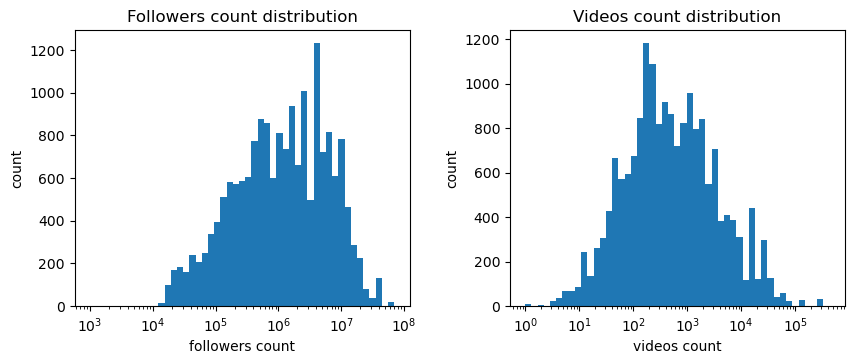

In [54]:
plt.figure(figsize=(7, 2))

sub1 = plt.subplot(121)
df['followers'].plot.hist(bins=np.logspace(3, np.log10(np.max(df['followers'])),50)) 
sub1.semilogx()
sub1.set_xlabel('followers count')
sub1.set_ylabel('count')
sub1.set_title("Followers count distribution")

sub2 = plt.subplot(122)
df['videos'].plot.hist(bins=np.logspace(np.log10(1), np.log10(np.max(df['videos'])),50)) 
sub2.semilogx()
sub2.set_xlabel('videos count')
sub2.set_ylabel('count')
sub2.set_title("Videos count distribution")

plt.subplots_adjust(left=-0.2, bottom=-0.5, wspace=0.3, hspace=0.4)
plt.savefig("../figures/channel distribution info.jpg", bbox_inches='tight', dpi=300)
plt.show()

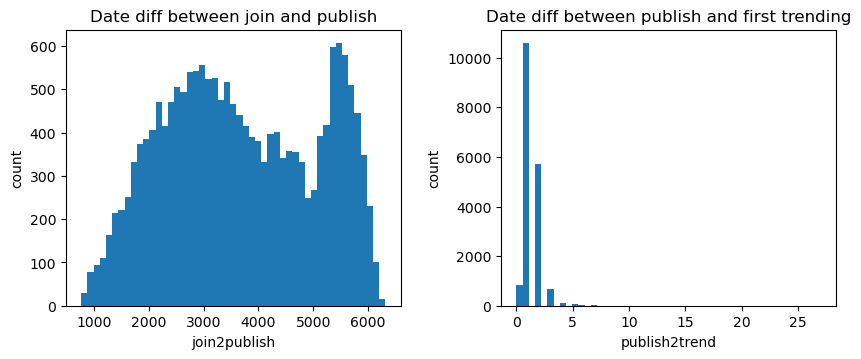

In [55]:
plt.figure(figsize=(7, 2))

sub1 = plt.subplot(121)
df['join2publish'].plot.hist(bins=np.linspace(np.min(df['join2publish']), np.max(df['join2publish']),50)) 
sub1.set_xlabel('join2publish')
sub1.set_ylabel('count')
sub1.set_title("Date diff between join and publish")

sub2 = plt.subplot(122)
df['publish2trend'].plot.hist(bins=np.linspace(np.min(df['publish2trend']), np.max(df['publish2trend']),50)) 
sub2.set_xlabel('publish2trend')
sub2.set_ylabel('count')
sub2.set_title("Date diff between publish and first trending")

plt.subplots_adjust(left=-0.2, bottom=-0.5, wspace=0.3, hspace=0.4)
plt.savefig("../figures/datetype info distribution.jpg", bbox_inches='tight', dpi=300)
plt.show()

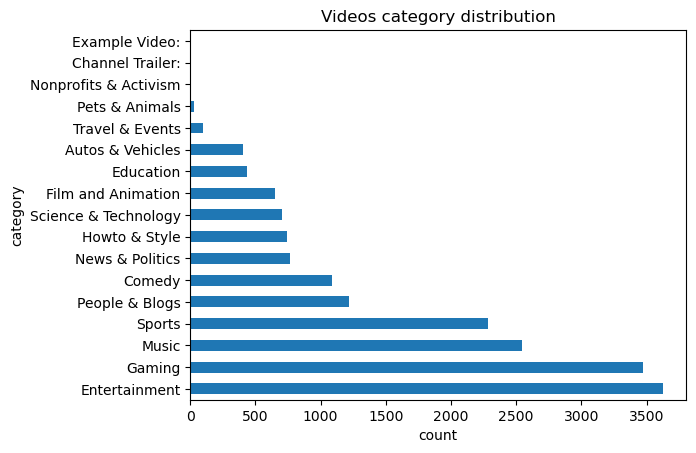

In [56]:
pd.value_counts(df['category_name']).plot.barh()
plt.xlabel('count')
plt.ylabel('category')
plt.title("Videos category distribution")
plt.savefig("../figures/category.jpg", bbox_inches='tight', dpi=300)
plt.show()

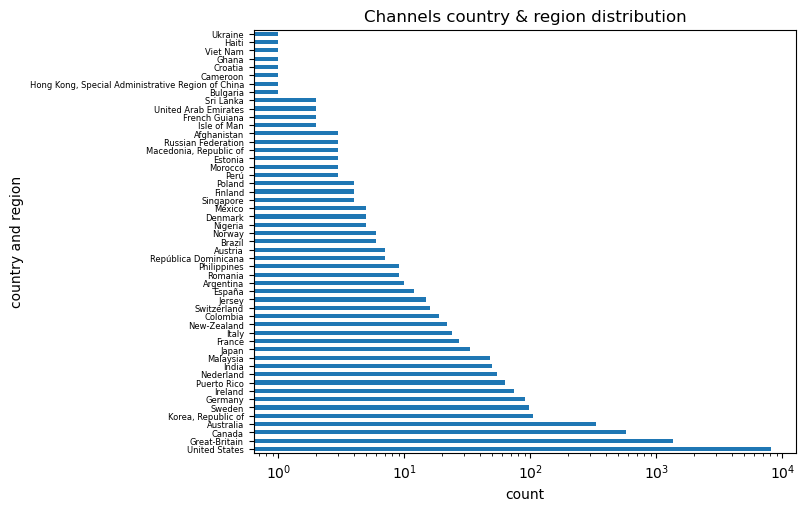

In [57]:
plt.figure(figsize=(7,5.5))
pd.value_counts(df['country']).plot.barh()
plt.semilogx()
plt.yticks(fontsize=6)
plt.xlabel('count')
plt.ylabel('country and region')
plt.title("Channels country & region distribution")
plt.savefig("../figures/country.jpg", bbox_inches='tight', dpi=300)
plt.show()

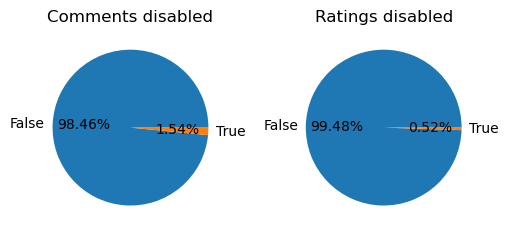

In [58]:
sub1 = plt.subplot(121)
sub1.pie([sum(1-df['comments_disabled']), sum(df['comments_disabled'])], labels=df['comments_disabled'].unique(), autopct='%.2f%%')
sub1.set_title("Comments disabled")

sub2 = plt.subplot(122)
sub2.pie([sum(1-df['ratings_disabled']), sum(df['ratings_disabled'])], labels=df['ratings_disabled'].unique(), autopct='%.2f%%')
sub2.set_title("Ratings disabled")

plt.subplots_adjust(left=0.2, bottom=-0.5, wspace=0.3, hspace=0.4)
plt.savefig("../figures/comments&ratings disabled.jpg", bbox_inches='tight', dpi=300)
plt.show()

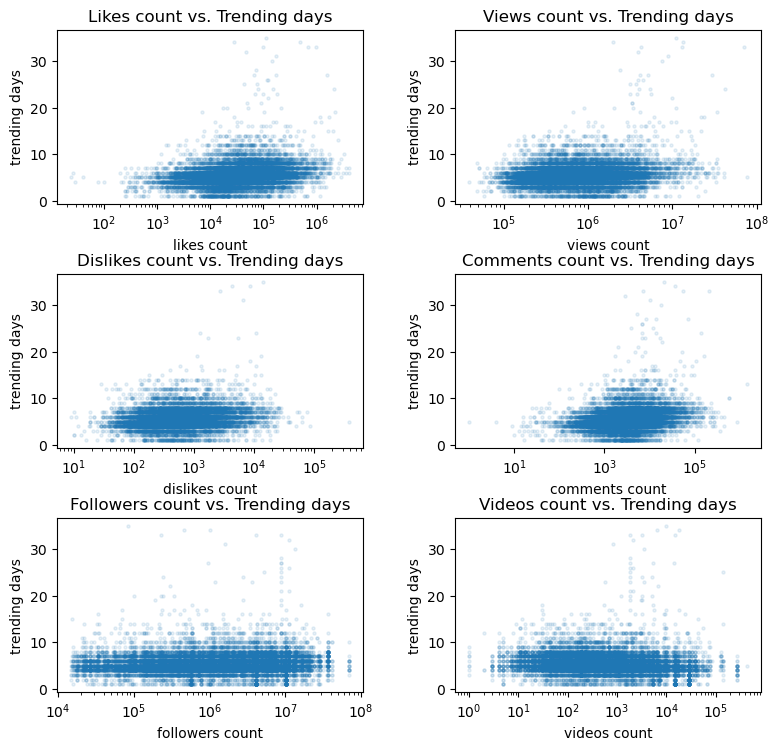

In [59]:
sub1 = plt.subplot(321)
sub1.scatter(df['likes'], df['trending_days'], s=5, alpha=0.1)
sub1.semilogx()
sub1.set_xlabel('likes count')
sub1.set_ylabel('trending days')
sub1.set_title("Likes count vs. Trending days")

sub2 = plt.subplot(322)
sub2.scatter(df['view_count'], df['trending_days'], s=5, alpha=0.1)
sub2.semilogx()
sub2.set_xlabel('views count')
sub2.set_ylabel('trending days')
sub2.set_title("Views count vs. Trending days")

sub3 = plt.subplot(323)
sub3.scatter(df['dislikes'], df['trending_days'], s=5, alpha=0.1)
sub3.semilogx()
sub3.set_xlabel('dislikes count')
sub3.set_ylabel('trending days')
sub3.set_title("Dislikes count vs. Trending days")

sub4 = plt.subplot(324)
sub4.scatter(df['comment_count'], df['trending_days'], s=5, alpha=0.1)
sub4.semilogx()
sub4.set_xlabel('comments count')
sub4.set_ylabel('trending days')
sub4.set_title("Comments count vs. Trending days")

sub5 = plt.subplot(325)
sub5.scatter(df['followers'], df['trending_days'], s=5, alpha=0.1)
sub5.semilogx()
sub5.set_xlabel('followers count')
sub5.set_ylabel('trending days')
sub5.set_title("Followers count vs. Trending days")

sub6 = plt.subplot(326)
sub6.scatter(df['videos'], df['trending_days'], s=5, alpha=0.1)
sub6.semilogx()
sub6.set_xlabel('videos count')
sub6.set_ylabel('trending days')
sub6.set_title("Videos count vs. Trending days")

plt.subplots_adjust(left=-0.2, bottom=-0.5, wspace=0.3, hspace=0.4)
plt.savefig("../figures/video info vs. Trending days.jpg", bbox_inches='tight', dpi=300)
plt.show()

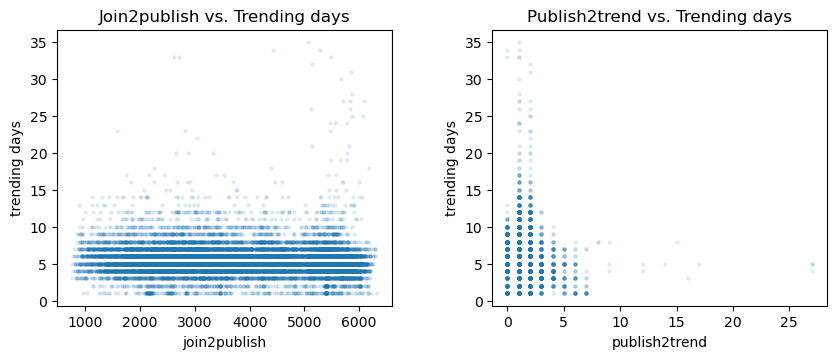

In [60]:
plt.figure(figsize=(7, 2))

sub1 = plt.subplot(121)
sub1.scatter(df['join2publish'], df['trending_days'], s=5, alpha=0.1)
sub1.set_xlabel('join2publish')
sub1.set_ylabel('trending days')
sub1.set_title("Join2publish vs. Trending days")

sub2 = plt.subplot(122)
sub2.scatter(df['publish2trend'], df['trending_days'], s=5, alpha=0.1)
sub2.set_xlabel('publish2trend')
sub2.set_ylabel('trending days')
sub2.set_title("Publish2trend vs. Trending days")

plt.subplots_adjust(left=-0.2, bottom=-0.5, wspace=0.3, hspace=0.4)
plt.savefig("../figures/datetype info distribution.jpg", bbox_inches='tight', dpi=300)
plt.show()

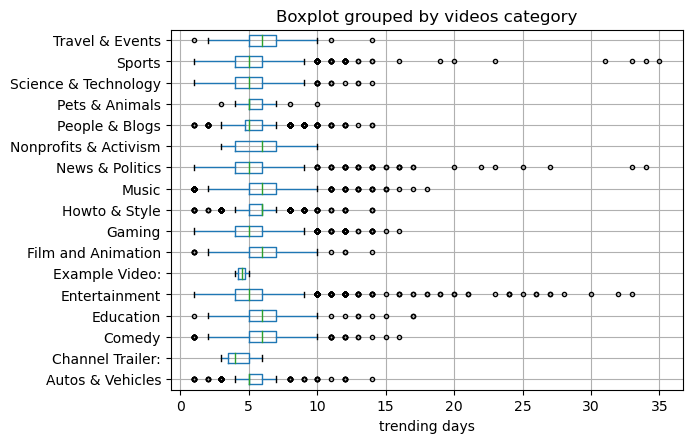

In [61]:
df[['trending_days','category_name']].boxplot(by='category_name', vert=False, sym='.')
plt.xlabel('trending days')
plt.title("Boxplot grouped by videos category")
plt.suptitle("")
plt.savefig("../figures/category boxplot.jpg", bbox_inches='tight', dpi=300)
plt.show()

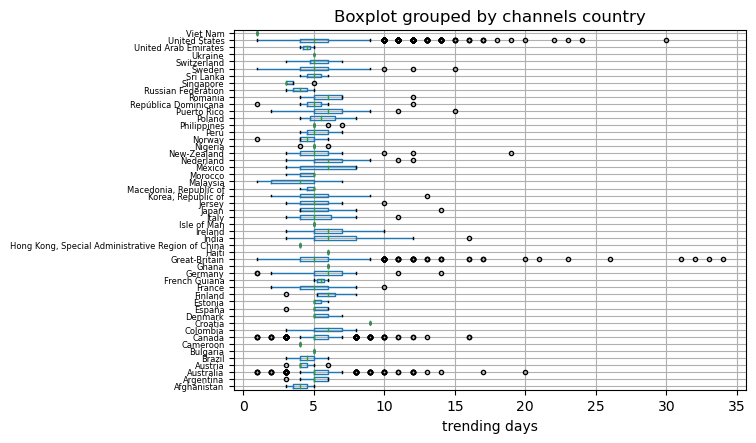

In [62]:
df[['trending_days','country']].boxplot(by='country', vert=False, sym='.')
plt.xlabel('trending days')
plt.yticks(fontsize=6)
plt.title("Boxplot grouped by channels country")
plt.suptitle("")
plt.savefig("../figures/country boxplot.jpg", bbox_inches='tight', dpi=300)
plt.show()

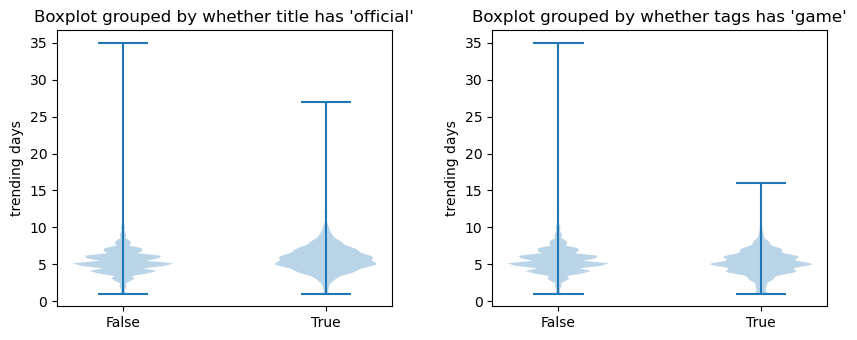

In [63]:
plt.figure(figsize=(7, 2))

sub1 = plt.subplot(121)
sub1.violinplot(dataset=[df[df['vtitle_official']==False]['trending_days'].values, df[df['vtitle_official']==True]['trending_days'].values])
sub1.set_xticks([1,2], [False,True])
sub1.set_ylabel('trending days')
sub1.set_title("Boxplot grouped by whether title has 'official'")

sub2 = plt.subplot(122)
sub2.violinplot(dataset=[df[df['tag_game']==False]['trending_days'].values, df[df['tag_game']==True]['trending_days'].values])
sub2.set_xticks([1,2], [False,True])
sub2.set_ylabel('trending days')
sub2.set_title("Boxplot grouped by whether tags has 'game'")

plt.subplots_adjust(left=-0.2, bottom=-0.5, wspace=0.3, hspace=0.4)
plt.savefig("../figures/text variables boxplot.jpg", bbox_inches='tight', dpi=300)
plt.show()

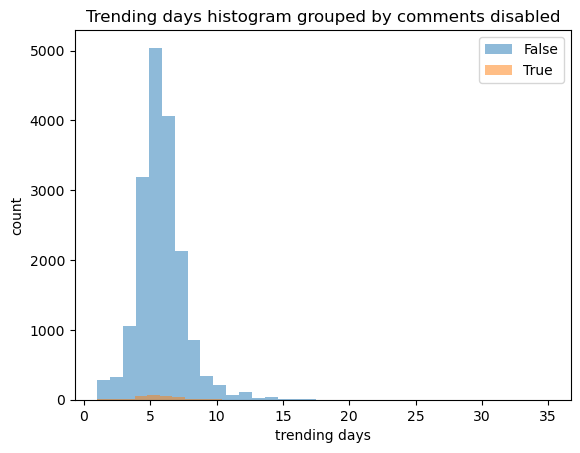

In [64]:
for c in df['comments_disabled'].unique():
    plt.hist(df[df['comments_disabled']==c]['trending_days'], alpha=0.5, label=c, bins=np.max(df['trending_days']))
plt.title("Trending days histogram grouped by comments disabled")
plt.legend()
plt.ylabel('count')
plt.xlabel('trending days')
plt.suptitle("")
plt.savefig("../figures/comments disabled hist.jpg", bbox_inches='tight', dpi=300)
plt.show()

# Data splitting & Preprocessing

In [26]:
y = df['trending_days']
X = df.drop(columns='trending_days')

In [27]:
cat_ftrs = ['category_name', 'country']
std_ftrs = ['likes', 'view_count', 'dislikes', 'comment_count', 'followers', 'videos', 'join2publish', 'publish2trend']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, cat_ftrs), ('std', StandardScaler(), std_ftrs)])

# Training models

In [28]:
def MLpipe_KFold_RMSE(X, y, stratify, preprocessor, alg, para_grid):
    #X: unprocessed feature matrix; y: target variable; alg: initialized ML algorithm, para_grid: correspondig parameter grid
    nr_states = 5
    test_scores = np.zeros(nr_states)
    final_models = []
    X_tests = []
    y_tests = []
    for i in range(nr_states):
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, stratify=X[stratify], random_state=42*i)
        X_tests.append(X_test)
        y_tests.append(y_test)
        kf = KFold(n_splits=4, shuffle=True, random_state=42*i)
        if alg not in [KNeighborsRegressor]:
            clf = alg(random_state=42*i)
        else:
            clf = alg()
        imputer = IterativeImputer(estimator=LinearRegression(), random_state=42*i)
        pipe = make_pipeline(preprocessor, imputer, clf)
        grid = GridSearchCV(pipe, param_grid=para_grid, scoring='neg_root_mean_squared_error', cv=kf, return_train_score=True, n_jobs=-1, verbose=True)
        grid.fit(X_other, y_other)
        results = pd.DataFrame(grid.cv_results_)
        print(results.shape)
        print('best model parameters:', grid.best_params_)
        print('validation score:', -grid.best_score_)
        final_models.append(grid)
        y_test_pred = final_models[-1].predict(X_test)
        test_scores[i] = np.sqrt(mean_squared_error(y_test, y_test_pred))
        print('test score:', test_scores[i])
    return final_models, test_scores, X_tests, y_tests

In [29]:
para_grid_lasso = {'lasso__alpha': np.logspace(-7,0,10).tolist()}
lasso = Lasso
final_models_lasso, test_scores_lasso, X_test_lasso, y_test_lasso = MLpipe_KFold_RMSE(X, y, 'comments_disabled', preprocessor, lasso, para_grid_lasso)
file = open('../results/lasso.save', 'wb')
pickle.dump((final_models_lasso, X_test_lasso, y_test_lasso), file)
file.close()
print('The mean of the test scores is', np.mean(test_scores_lasso))
print('The std of the test scores is', np.std(test_scores_lasso))

Fitting 4 folds for each of 10 candidates, totalling 40 fits
(10, 19)
best model parameters: {'lasso__alpha': 0.000774263682681127}
validation score: 1.9023666771989771
test score: 1.9708230633148633
Fitting 4 folds for each of 10 candidates, totalling 40 fits
(10, 19)
best model parameters: {'lasso__alpha': 0.000774263682681127}
validation score: 1.9202824453078726
test score: 1.9154865997037331
Fitting 4 folds for each of 10 candidates, totalling 40 fits
(10, 19)
best model parameters: {'lasso__alpha': 0.000774263682681127}
validation score: 1.9152833188131795
test score: 1.9480821608188803
Fitting 4 folds for each of 10 candidates, totalling 40 fits
(10, 19)
best model parameters: {'lasso__alpha': 0.000774263682681127}
validation score: 1.9368436867786232
test score: 1.8284042746747062
Fitting 4 folds for each of 10 candidates, totalling 40 fits
(10, 19)
best model parameters: {'lasso__alpha': 0.000774263682681127}
validation score: 1.907423403534485
test score: 1.9407890192756685
T

In [30]:
ridge = Ridge
para_grid_ridge = {'ridge__alpha': np.logspace(-7,0,10).tolist()}
final_models_ridge, test_scores_ridge, X_test_ridge, y_test_ridge = MLpipe_KFold_RMSE(X, y, 'comments_disabled', preprocessor, ridge, para_grid_ridge)
file = open('../results/ridge.save', 'wb')
pickle.dump((final_models_ridge, X_test_ridge, y_test_ridge), file)
file.close()
print('The mean of the test scores is', np.mean(test_scores_ridge))
print('The std of the test scores is', np.std(test_scores_ridge))

Fitting 4 folds for each of 10 candidates, totalling 40 fits
(10, 19)
best model parameters: {'ridge__alpha': 1.0}
validation score: 1.9037869717081068
test score: 1.9701274528128716
Fitting 4 folds for each of 10 candidates, totalling 40 fits
(10, 19)
best model parameters: {'ridge__alpha': 1.0}
validation score: 1.9215936407770497
test score: 1.9201904779493304
Fitting 4 folds for each of 10 candidates, totalling 40 fits
(10, 19)
best model parameters: {'ridge__alpha': 1.0}
validation score: 1.9158139218656387
test score: 1.9480788422992124
Fitting 4 folds for each of 10 candidates, totalling 40 fits
(10, 19)
best model parameters: {'ridge__alpha': 1.0}
validation score: 1.9389270820298117
test score: 1.8263815467240727
Fitting 4 folds for each of 10 candidates, totalling 40 fits
(10, 19)
best model parameters: {'ridge__alpha': 1.0}
validation score: 1.9075659505685927
test score: 1.9420474536211951
The mean of the test scores is 1.9213651546813364
The std of the test scores is 0.050

In [31]:
RF = RandomForestRegressor
para_grid_RF = {'randomforestregressor__max_depth': [1, 3, 10, 30], 'randomforestregressor__max_features': [0.25, 0.5, 0.75, 1.0]}
final_models_RF, test_scores_RF, X_test_RF, y_test_RF = MLpipe_KFold_RMSE(X, y, 'comments_disabled', preprocessor, RF, para_grid_RF)
file = open('../results/RF.save', 'wb')
pickle.dump((final_models_RF, X_test_RF, y_test_RF), file)
file.close()
print('The mean of the test scores is', np.mean(test_scores_RF))
print('The std of the test scores is', np.std(test_scores_RF))

Fitting 4 folds for each of 16 candidates, totalling 64 fits
(16, 20)
best model parameters: {'randomforestregressor__max_depth': 30, 'randomforestregressor__max_features': 0.25}
validation score: 1.7725960762030102
test score: 1.7874775138116055
Fitting 4 folds for each of 16 candidates, totalling 64 fits
(16, 20)
best model parameters: {'randomforestregressor__max_depth': 30, 'randomforestregressor__max_features': 0.25}
validation score: 1.7898465436165238
test score: 1.7330419086982376
Fitting 4 folds for each of 16 candidates, totalling 64 fits
(16, 20)
best model parameters: {'randomforestregressor__max_depth': 30, 'randomforestregressor__max_features': 0.25}
validation score: 1.7844104132945926
test score: 1.7553058945402398
Fitting 4 folds for each of 16 candidates, totalling 64 fits
(16, 20)
best model parameters: {'randomforestregressor__max_depth': 30, 'randomforestregressor__max_features': 0.25}
validation score: 1.8162938707747638
test score: 1.6634456680322305
Fitting 4 fo

In [32]:
KNR = KNeighborsRegressor
para_grid_KNR = {'kneighborsregressor__n_neighbors': [1, 3, 10, 30, 100]}
final_models_KNR, test_scores_KNR, X_test_KNR, y_test_KNR = MLpipe_KFold_RMSE(X, y, 'comments_disabled', preprocessor, KNR, para_grid_KNR)
file = open('../results/KNR.save', 'wb')
pickle.dump((final_models_KNR, X_test_KNR, y_test_KNR), file)
file.close()
print('The mean of the test scores is', np.mean(test_scores_KNR))
print('The std of the test scores is', np.std(test_scores_KNR))

Fitting 4 folds for each of 5 candidates, totalling 20 fits
(5, 19)
best model parameters: {'kneighborsregressor__n_neighbors': 30}
validation score: 1.8562345903655042
test score: 1.91064681072129
Fitting 4 folds for each of 5 candidates, totalling 20 fits
(5, 19)
best model parameters: {'kneighborsregressor__n_neighbors': 10}
validation score: 1.8699580610817677
test score: 1.8400655350327266
Fitting 4 folds for each of 5 candidates, totalling 20 fits
(5, 19)
best model parameters: {'kneighborsregressor__n_neighbors': 30}
validation score: 1.8672486429233173
test score: 1.8672550591887325
Fitting 4 folds for each of 5 candidates, totalling 20 fits
(5, 19)
best model parameters: {'kneighborsregressor__n_neighbors': 30}
validation score: 1.8997484142832843
test score: 1.735693623786738
Fitting 4 folds for each of 5 candidates, totalling 20 fits
(5, 19)
best model parameters: {'kneighborsregressor__n_neighbors': 30}
validation score: 1.867268864949187
test score: 1.8565954729806042
The 

In [33]:
final_models_XGB = []
X_test_XGB = []
y_test_XGB = []
test_scores_XGB = np.zeros(5)
for i in range(5):
    X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.6, random_state=42*i)
    X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, train_size=0.5, random_state=42*i)
    
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)
    
    df_test = pd.DataFrame(data=X_test_prep, columns = preprocessor.get_feature_names_out())
    X_test_XGB.append(df_test)
    y_test_XGB.append(y_test)
        
    param_grid = {"learning_rate": [0.03, 0.1, 0.3, 1], "max_depth": [3, 10, 30, 100]}
    
    test_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        XGB = xgboost.XGBRegressor(**params, random_state=42*i, n_estimators=1000, colsample_bytree=0.9, subsample=0.66)
        XGB.fit(X_train_prep, y_train, early_stopping_rounds=50, eval_set=[(X_val_prep, y_val)], verbose=False)
        models.append(XGB)
        y_test_pred = XGB.predict(X_test_prep)
        test_score[p] = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    final_models_XGB.append(models[np.argmax(test_score)])
    print('best model parameters:', ParameterGrid(param_grid)[np.argmax(test_score)])
    test_scores_XGB[i] = np.max(test_score)
    print('test score:', test_scores_XGB[i])
file = open('../results/XGB.save', 'wb')
pickle.dump((final_models_XGB, X_test_XGB, y_test_XGB), file)
file.close()
print('The mean of the test scores is', np.mean(test_scores_XGB))
print('The std of the test scores is', np.std(test_scores_XGB))

best model parameters: {'max_depth': 30, 'learning_rate': 1}
test score: 2.016051902872444
best model parameters: {'max_depth': 3, 'learning_rate': 1}
test score: 1.8902268547545193
best model parameters: {'max_depth': 10, 'learning_rate': 1}
test score: 2.022843892135049
best model parameters: {'max_depth': 30, 'learning_rate': 1}
test score: 1.8672780497350272
best model parameters: {'max_depth': 30, 'learning_rate': 1}
test score: 2.0695262017032765
The mean of the test scores is 1.9731853802400632
The std of the test scores is 0.07960344220178188


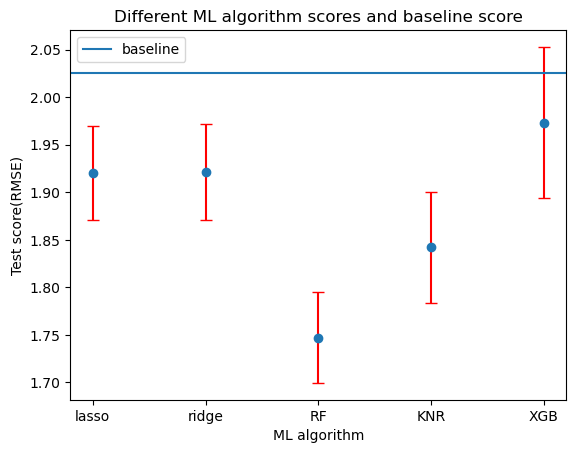

In [65]:
baseline = np.sqrt(mean_squared_error(y, np.mean(y)*np.ones(len(y))))
plt.errorbar(x=['lasso', 'ridge', 'RF', 'KNR', 'XGB'], y=[np.mean(test_scores_lasso), np.mean(test_scores_ridge), np.mean(test_scores_RF), np.mean(test_scores_KNR), np.mean(test_scores_XGB)], 
             yerr=[np.std(test_scores_lasso), np.std(test_scores_ridge), np.std(test_scores_RF), np.std(test_scores_KNR), np.std(test_scores_XGB)], fmt='o', ecolor='r', capsize=4)
plt.axhline(baseline, label='baseline')
plt.xlabel('ML algorithm')
plt.ylabel('Test score(RMSE)')
plt.title('Different ML algorithm scores and baseline score')
plt.legend()
plt.savefig("../figures/test scores.jpg", bbox_inches='tight', dpi=300)
plt.show()

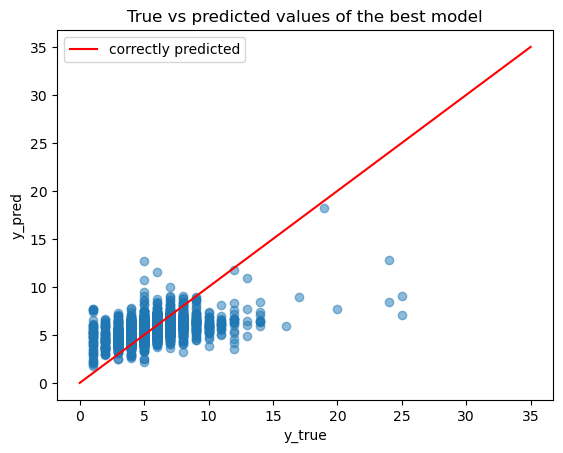

In [66]:
y_pred_best = final_models_RF[np.argmin(test_scores_RF)].predict(X_test_RF[np.argmin(test_scores_RF)])
plt.scatter(y_test_RF[np.argmin(test_scores_RF)].values, y_pred_best, alpha=0.5)
plt.plot(np.linspace(0,35,100), np.linspace(0,35,100), label='correctly predicted', color='r')
plt.legend()
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.title('True vs predicted values of the best model')
plt.savefig("../figures/true vs predict.jpg", bbox_inches='tight', dpi=300)
plt.show()

# Feature Importance

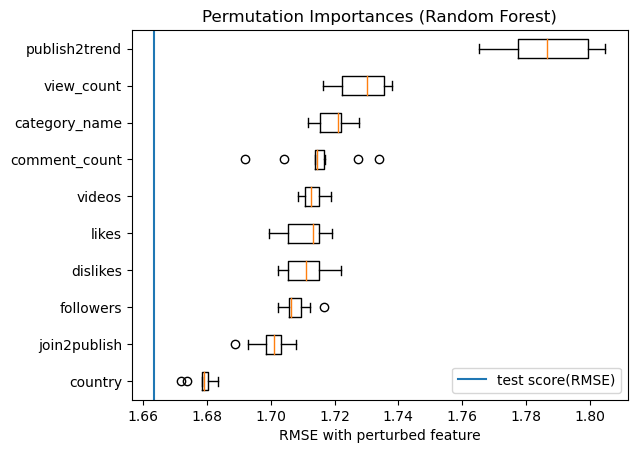

In [67]:
import warnings
warnings.simplefilter(action='ignore')

feature_names = X_test_RF[np.argmin(test_scores_RF)].columns
np.random.seed(42)
scores = np.zeros([len(feature_names), 10])
for i in range(len(feature_names)):
    acc_scores = []
    for j in range(10):
        X_test_shuffled = X_test_RF[np.argmin(test_scores_RF)].copy()
        X_test_shuffled[feature_names[i]] = np.random.permutation(X_test_RF[np.argmin(test_scores_RF)][feature_names[i]].values)
        acc_scores.append(np.sqrt(mean_squared_error(y_test_RF[np.argmin(test_scores_RF)], final_models_RF[np.argmin(test_scores_RF)].predict(X_test_shuffled))))
    scores[i] = acc_scores
sorted_indcs = np.argsort(np.mean(scores, 1))[-10:]
plt.boxplot(scores[sorted_indcs].T, labels=feature_names[sorted_indcs], vert=False)
plt.axvline(np.min(test_scores_RF), label='test score(RMSE)')
plt.title("Permutation Importances (Random Forest)")
plt.xlabel('RMSE with perturbed feature')
plt.legend()
plt.savefig("../figures/permutation importance.jpg", bbox_inches='tight', dpi=300)
plt.show()

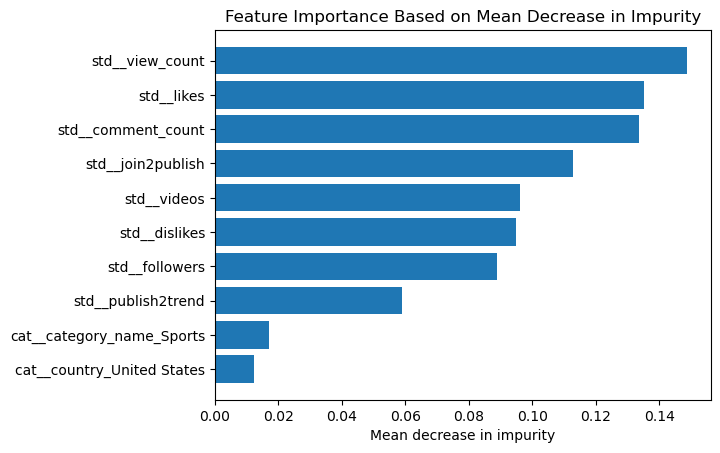

In [68]:
importance = final_models_RF[np.argmin(test_scores_RF)].best_estimator_[2].feature_importances_
plt.barh(final_models_RF[np.argmin(test_scores_RF)].best_estimator_[0].get_feature_names_out()[np.argsort(importance)[-10:]], sorted(importance, reverse=False)[-10:])
plt.title("Feature Importance Based on Mean Decrease in Impurity")
plt.xlabel('Mean decrease in impurity')
plt.savefig("../figures/RF importance.jpg", bbox_inches='tight', dpi=300)
plt.show()

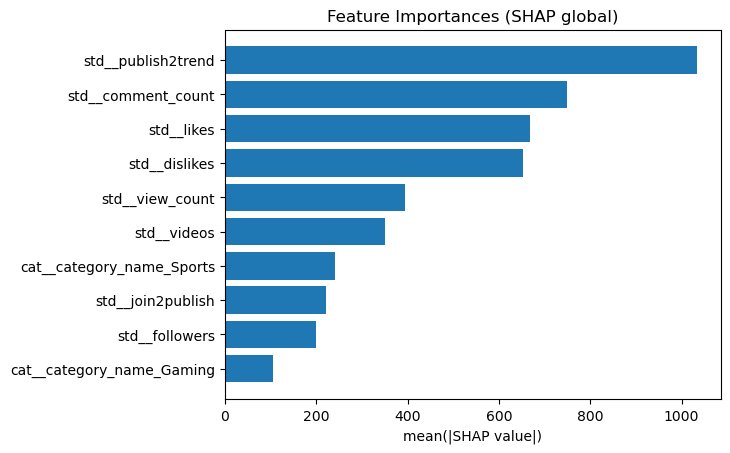

In [69]:
shap.initjs()
explainer = shap.TreeExplainer(final_models_RF[np.argmin(test_scores_RF)].best_estimator_[2])
shap_values = explainer.shap_values(final_models_RF[np.argmin(test_scores_RF)].best_estimator_[0].transform(X_test_RF[np.argmin(test_scores_RF)]))
shap_summary = np.sum(np.abs(shap_values), axis=0)
plt.barh(final_models_RF[np.argmin(test_scores_RF)].best_estimator_[0].get_feature_names_out()[np.argsort(shap_summary)[-10:]], shap_summary[np.argsort(shap_summary)[-10:]])
plt.title("Feature Importances (SHAP global)")
plt.xlabel('mean(|SHAP value|)')
plt.savefig("../figures/shap global.jpg", bbox_inches='tight', dpi=300)
plt.show()

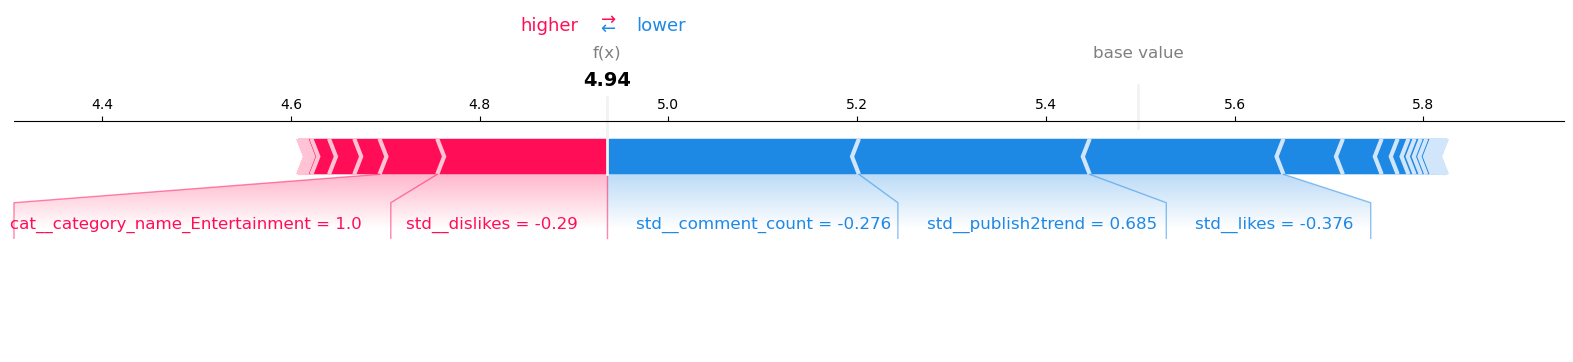

In [70]:
index = 1
shap.force_plot(explainer.expected_value, shap_values[index,:], 
                features=np.around(final_models_RF[np.argmin(test_scores_RF)].best_estimator_[0].transform(X_test_RF[np.argmin(test_scores_RF)])[index], 3), 
                feature_names=final_models_RF[np.argmin(test_scores_RF)].best_estimator_[0].get_feature_names_out(), 
                matplotlib=True, show=False)
plt.savefig("../figures/local1.jpg", bbox_inches='tight', dpi=300)
plt.show()

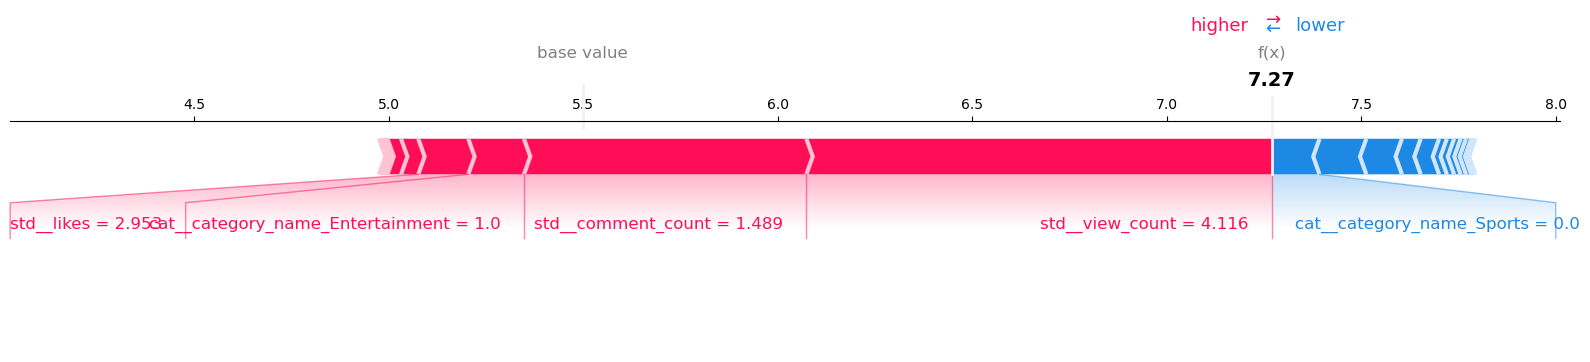

In [71]:
index = 100
shap.force_plot(explainer.expected_value, shap_values[index,:], 
                features=np.around(final_models_RF[np.argmin(test_scores_RF)].best_estimator_[0].transform(X_test_RF[np.argmin(test_scores_RF)])[index], 3), 
                feature_names=final_models_RF[np.argmin(test_scores_RF)].best_estimator_[0].get_feature_names_out(), 
                matplotlib=True, show=False)
plt.savefig("../figures/local2.jpg", bbox_inches='tight', dpi=300)
plt.show()

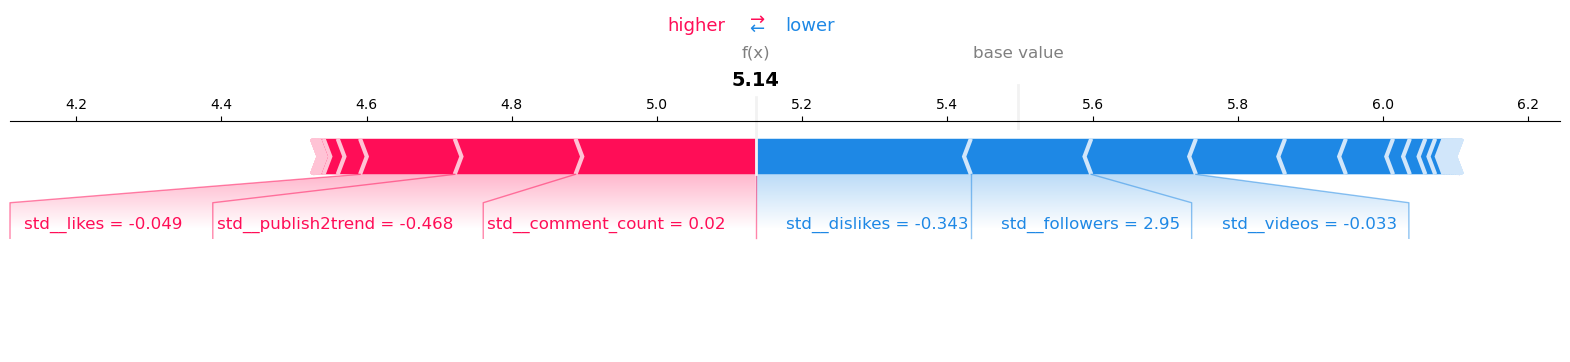

In [72]:
index = 3000
shap.force_plot(explainer.expected_value, shap_values[index,:], 
                features=np.around(final_models_RF[np.argmin(test_scores_RF)].best_estimator_[0].transform(X_test_RF[np.argmin(test_scores_RF)])[index], 3), 
                feature_names=final_models_RF[np.argmin(test_scores_RF)].best_estimator_[0].get_feature_names_out(), 
                matplotlib=True, show=False)
plt.savefig("../figures/local3.jpg", bbox_inches='tight', dpi=300)
plt.show()